In [1737]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Distribution

import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer

In [1738]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

%matplotlib inline

In [1739]:
from typing import Any ,List

General case:
- Choose a prior for $Z$: $p(Z)$.
- Choose an observation model: $p_\theta(X|Z)$
- Choose a variational posterior: $q_{\gamma}(\mathbf{z} | \mathbf{x})$

- Choose a missing model: $p_{\phi}(\mathbf{S} | \mathbf{X^o, X^m})$


The ELBO in the MNAR case is

$$ E_{(\mathbf{z}_1, \mathbf{x}_1^m)...(\mathbf{z}_K, \mathbf{x}_K^m)} \left[ \log \frac{1}{K} \sum_{k=1}^K \frac{p_{\phi}(\mathbf{s} | \mathbf{x}^o, \mathbf{x}_k^m) p_{\theta}(\mathbf{x}^o | \mathbf{z}_k) p(\mathbf{z}_k)}{q_{\gamma}(\mathbf{z} | \mathbf{x}^o)} \right]$$

### Classic case
The model we are building has a Gaussian prior and a Gaussian observation model (also the decoder ($z \rightarrow x$) ),

$$ p(\mathbf{z}) = \mathcal{N}(\mathbf{z} | \mathbf{0}, \mathbf{I})$$

$$ p_\theta(\mathbf{x} | \mathbf{z}) = \mathcal{N}(\mathbf{x} | \mathbf{\mu}_{\theta}(\mathbf{z}), \sigma^2\mathbf{I})$$

$$ p_\theta(\mathbf{x}) = \int p_\theta(\mathbf{x} | \mathbf{z})p(\mathbf{z}) d\mathbf{z}$$

where $\mathbf{\mu}_{\theta}(\mathbf{z}): \mathbb{R}^d \rightarrow \mathbb{R}^p $ in general is a deep neural net, but in this case is a linear mapping, $\mathbf{\mu} = \mathbf{Wz + b}$.

The variational posterior (also the encoder ($x \rightarrow z$) ) is also Gaussian

$$q_{\gamma}(\mathbf{z} | \mathbf{x}) = \mathcal{N}(\mathbf{z} | \mu_{\gamma}(\mathbf{x}), \sigma_{\gamma}(\mathbf{x})^2 \mathbf{I})$$

If the missing process is *missing at random*, it is ignorable and the ELBO becomes, as described in [the MIWAE paper](https://arxiv.org/abs/1812.02633)

$$ E_{\mathbf{z}_1...\mathbf{z}_K} \left[ \log \frac{1}{K}\sum_{k=1}^K \frac{p_{\theta}(\mathbf{x^o} | \mathbf{z}_k)p(\mathbf{z}_k)}{q_{\gamma}(\mathbf{z}_k | \mathbf{x^o})} \right] $$

When the missing process is MNAR it is non-ignorable and we need to include the missing model. In this example we include the missing model as a logistic regression in each feature dimension

$$ p_{\phi}(\mathbf{s} | \mathbf{x^o, x^m}) = \text{Bern}(\mathbf{s} | \pi_{\phi}(\mathbf{x^o, x^m}))$$

$$ \pi_{\phi, j}(x_j) = \frac{1}{1 + e^{-\text{logits}_j}} $$

$$ \text{logits}_j = W_j (x_j - b_j) $$

The ELBO in the MNAR case becomes

$$ E_{(\mathbf{z}_1, \mathbf{x}_1^m)...(\mathbf{z}_K, \mathbf{x}_K^m)} \left[ \log \frac{1}{K} \sum_{k=1}^K \frac{p_{\phi}(\mathbf{s} | \mathbf{x}^o, \mathbf{x}_k^m) p_{\theta}(\mathbf{x}^o | \mathbf{z}_k) p(\mathbf{z}_k)}{q_{\gamma}(\mathbf{z} | \mathbf{x}^o)} \right]$$

with $ z \sim q_{\gamma}(z|x^o), x^m\sim p_\theta(x^m|z)$

### Constant to define

 - $K$ = $n_{\text{samples}}$ the number of sample to estimate the expectation
 - $n_{\text{latent}}$ the dimension of the latent space where $z$ lives


## Imputation

 - RMSE imputation (easy to implement)
$$
\hat{x}^m = \mathbb{E}[x^m|x^o,s] \approx \sum_{k=1}^K \alpha_k \mathbb{E}[x^m|x^o,s]  ~~\text{with} ~~ \alpha _ k =\frac{w_k}{w_1 + ... + w_K}
$$
 - Absolute value imputation (harder) 5NOT IMPLEMENTED
$$
F_j(x_j)= \mathbb{E}[\mathbb{1}_{x_j^m \leq x_j}|x^o,s] \approx \sum_{k=1}^K \alpha_k F_{x_j|x^o,s}(x_j) ~~\text{with} ~~ \alpha_k =\frac{w_k}{w_1 + ... + w_K}
$$

### Load data
Here we use the white-wine dataset from the UCI database

In [1740]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
data = np.array(pd.read_csv(url, low_memory=False, sep=';'))
# ---- drop the classification attribute
data = data[:, :-1]

### Settings

In [1741]:
N, D = data.shape
n_latent = D - 1
n_hidden = 128
n_samples = 20
max_iter = 30000
batch_size = 16

### Standardize data

In [1742]:
# ---- standardize data
data = data - np.mean(data, axis=0)
data = data / np.std(data, axis=0)

# ---- random permutation
p = np.random.permutation(N)
data = data[p, :]

# ---- we use the full dataset for training here, but you can make a train-val split
Xtrain = data.copy()
Xval = Xtrain.copy()

### Introduce missing 
Here we denote
- Xnan: data matrix with np.nan as the missing entries
- Xz: data matrix with 0 as the missing entries
- S: missing mask 

The missing process depends on the missing data itself:
- in half the features, set the feature value to missing when it is higher than the feature mean

In [1743]:
def transform(data: np.array, d1, d2, threshold, prob, sign: int = 1) -> np.array:
    """
    Introduce missing data.
    Mechanism: sign * x[i, d2] > threshold => x[i, d1] missing with probability prob.
    
    Args:
    - data (np.array): Input data array.
    - d1 (int): Index of the column where missing data will be introduced.
    - d2 (int): Index of the column used for the threshold comparison.
    - threshold (float): Threshold value for the comparison.
    - prob (float): Probability of introducing missing data.
    - sign (int, optional): Sign of the comparison (1 or -1). Default is 1.

    Returns:
    - np.array: Transformed data with missing values introduced based on the specified mechanism.
    """
    transformed_data = np.copy(data)

    # Apply the transformation based on the specified mechanism
    mask = sign * data[:, d2] > threshold
    missing_values = np.random.choice([True, False], size=len(mask), p=[prob, 1 - prob])
    transformed_data[mask & missing_values, d1] = np.nan

    return transformed_data

In [1744]:
test = transform(data,1,1,0.5,0.5)
print(f'{np.isnan(test).sum()} / {test.shape[0]*test.shape[1]}')

595 / 53878


In [1745]:
# ---- introduce missing process
Xnan = Xtrain.copy()
Xz = Xtrain.copy()

mean = np.mean(Xnan[:, :int(D / 2)], axis=0)
ix_larger_than_mean = Xnan[:, :int(D / 2)] > mean

Xnan[:, :int(D / 2)][ix_larger_than_mean] = np.nan
Xz[:, :int(D / 2)][ix_larger_than_mean] = 0

S = np.array(~np.isnan(Xnan), dtype=np.float32)

In [1746]:
def check_nan(tens,name=None):
    if torch.isnan(tens).any().item():
        print(name)
        print(tens)

## Define Distributions

In [1747]:
class Distributions():
    def __init__(self) -> None:
        pass
    def rsample(self, sample_shape):
        print("Not implemented")
        pass
    def log_prob(self, value):
        print("Not implemented")
        pass

In [1748]:
class GaussDistribution(Distributions):
    """
    Gaussian distribution with mean (mu) and standard deviation (sigma).

    Parameters:
    - loc (Any): Mean of the distribution. Default is 0.
    - scale (Any): Standard deviation of the distribution. Default is 1.

    Methods:
    - rsample(sample_shape): Generates random samples from the distribution.
    - log_prob(value): Computes the log probability of a given value under the distribution.
    """

    def __init__(self, loc: Any = 0., scale: Any = 1.) -> None:
        """
        Initializes the Gaussian distribution with given mean and standard deviation.

        Args:
        - loc (Any): Mean of the distribution. Default is 0.
        - scale (Any): Standard deviation of the distribution. Default is 1.
        """
        super().__init__()
        
        if not torch.is_tensor(loc):
            self.mu = torch.tensor(loc, dtype=torch.float32)
        else:
            self.mu = loc

        if not torch.is_tensor(scale):
            self.sigma = torch.tensor(scale, dtype=torch.float32)
        else:
            self.sigma = scale

    def sample(self, sample_shape:torch.Size = torch.Size()):
        """
        Generates random samples from the Gaussian distribution.

        Args:
        - sample_shape: Shape of the random samples to be generated.

        Returns:
        - samples: Random samples from the distribution.
        """
        if not isinstance(sample_shape, torch.Size):
            sample_shape = torch.Size(sample_shape)
        
        shape = sample_shape + self.mu.size()
        with torch.no_grad():
            eps = torch.randn(shape, dtype=self.mu.dtype)
            return self.mu + eps * self.sigma
    
    def rsample(self, sample_shape:torch.Size = torch.Size()):
        """
        Generates random samples from the Gaussian distribution.

        Args:
        - sample_shape: Shape of the random samples to be generated.

        Returns:
        - samples: Random samples from the distribution.
        """
        if not isinstance(sample_shape, torch.Size):
            sample_shape = torch.Size(sample_shape)
        
        shape = sample_shape + self.mu.size()

        eps = torch.randn(shape, dtype=self.mu.dtype)
        
        return self.mu + eps * self.sigma
    

    def log_prob(self, value):
        """
        Computes the log probability of a given value under the Gaussian distribution.

        Args:
        - value: Tensor of values for which log probabilities are computed.

        Returns:
        - log_p: Log probabilities of the given values.
        """
        eps = torch.finfo(torch.float32).eps

        log_p = - 0.5 * torch.log(2 * torch.tensor(np.pi, dtype=torch.float32)) \
                - 0.5 * torch.log(self.sigma**2 + eps) \
                - 0.5 * torch.square(value - self.mu) / (self.sigma**2 + eps)

        return log_p


In [1749]:
class BernoulliDistribution(Distributions):
    """
    Bernoulli distribution with parameter (p).

    Parameters:
    - p (Any): Probability of success. Default is 0.5.

    Methods:
    - sample(sample_shape): Generates random samples from the distribution.
    - rsample(sample_shape): Generates random samples with reparameterization.
    - log_prob(value): Computes the log probability of a given value under the distribution.
    """

    def __init__(self, probs: Any = None, logits = None) -> None:
        """
        Initializes the Bernoulli distribution with the given probability.

        Args:
        - probs (Any): Probability of success. Default is 0.5.
        """
        super().__init__()
        if probs is not None:
            if not torch.is_tensor(probs):
                p = torch.tensor(probs, dtype=torch.float32)
            else:
                p = probs
        
        elif logits is not None:
            if not torch.is_tensor(logits):
                logip = torch.tensor(logits, dtype=torch.float32)
            else:
                logip = logits
            p = torch.sigmoid(logip)
            
        self.p = p

    def sample(self, sample_shape: torch.Size = torch.Size()):
        """
        Generates random samples from the Bernoulli distribution.

        Args:
        - sample_shape: Shape of the random samples to be generated.

        Returns:
        - samples: Random samples from the distribution.
        """
        if not isinstance(sample_shape, torch.Size):
            sample_shape = torch.Size(sample_shape)

        with torch.no_grad():
            samples = torch.bernoulli(self.p.expand(sample_shape + self.p.size()))
            return samples


    def log_prob(self, value):
        """
        Computes the log probability of a given value under the Bernoulli distribution.

        Args:
        - value: Tensor of values for which log probabilities are computed.

        Returns:
        - log_p: Log probabilities of the given values.
        """
        log_p = value * torch.log(self.p + 1e-12) + (1 - value) * torch.log(1 - self.p + 1e-12)
        return log_p

## Define Modules

Here we define different modules, to prepare different encoders and decoders for our experiments.

In [1750]:
class Clip(nn.Module):
    def __init__(self, x_min = -10, x_max = 10, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.x_min = x_min
        self.x_max = x_max
    
    def forward(self, x):
        return torch.clip(x, self.x_min, self.x_max)

In [1751]:
RELU = "relu"
TANH = "tanh"

In [1752]:
class MultiPerceptron(nn.Module):
    def __init__(self, layer_sizes, activation: RELU or TANH = RELU, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        if activation == TANH:
            activation = nn.Tanh
        else:
            activation = nn.ReLU

        layers = [nn.Identity()]

        for i in range(1, len(layer_sizes)):
            layers.append(nn.Linear(layer_sizes[i-1], layer_sizes[i]))
            layers.append(activation())

        # Create the Sequential module with all the layers
        self.mlp = nn.Sequential(*layers)
    
    def forward(self,x):
        return self.mlp(x)


In [1753]:
class ToGaussParams(nn.Module):
    def __init__(self, input_size, output_size, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.to_mu = nn.Linear(in_features=input_size, out_features=output_size)
        self.to_logsigma2 = nn.Sequential(nn.Linear(in_features=input_size, out_features=output_size), Clip())

    def forward(self, x):
        return self.to_mu(x), torch.sqrt(torch.exp(self.to_logsigma2(x)))
    
    

In [1754]:
class ToGaussParams2(nn.Module):
    def __init__(self, input_size, output_size, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.to_mu = nn.Linear(in_features=input_size, out_features=output_size)
        logsigma_value = torch.zeros((1,))
        self.logsigma2 = nn.Parameter(logsigma_value)

    def forward(self, x):
        return self.to_mu(x), torch.exp(self.logsigma2)
    
    

In [1755]:
class GaussianCoder(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers = [32,32], activation: RELU or TANH = RELU, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.mlp = MultiPerceptron(layer_sizes=[input_size] + hidden_layers, activation=activation)

        self.to_gauss_params = ToGaussParams(input_size=hidden_layers[-1], output_size=output_size)

    def forward(self, x):
        z = self.mlp(x)
        return self.to_gauss_params(z)

In [1756]:
class BiaisBeforeWeight(nn.Module):
    def __init__(self, input_size, output_size, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        w_value = torch.randn(size=(input_size,output_size)) / np.sqrt(input_size*output_size)

        b_value = torch.randn(size=(input_size,))

        self.w = nn.Parameter(w_value)

        self.b = nn.Parameter(b_value)

    def forward(self, x):
        return (x - self.b) @ self.w


In [1757]:
class Logits(nn.Module):
    def __init__(self, input_size, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        w_value = torch.randn(size=(input_size,)) / np.sqrt(input_size)

        b_value = torch.randn(size=(input_size,)) / np.sqrt(input_size)

        self.w = nn.Parameter(w_value)

        self.b = nn.Parameter(b_value)

    def forward(self, x):
        return  self.w * (x - self.b) 

In [1758]:
GAUSS = "gauss"
BERNOUILLI = "bern"
STUDENT = "student"


NOTMIWAE = "not_miwae"
MIWAE = "miwae"

In [1759]:
class PaperEncoder(nn.Module):
    def __init__(self,n_input, n_output, n_hidden = 100, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.mlp = MultiPerceptron([n_input,n_hidden,n_hidden],TANH)
        self.to_mu = nn.Linear(n_hidden,n_output)
        self.to_logsigma2 = nn.Sequential(nn.Linear(n_hidden,n_output),Clip())
    
    def forward(self,x):
        x = self.mlp(x)
        return self.to_mu(x), torch.exp(self.to_logsigma2(x))

In [1760]:
class PaperDecoder(nn.Module):
    def __init__(self,n_input, n_output, n_hidden = 100, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.mlp = MultiPerceptron([n_input,n_hidden,n_hidden],TANH)
        self.to_mu = nn.Linear(n_hidden,n_output)
        self.to_sigma = nn.Sequential(nn.Linear(n_hidden,n_output), nn.Softplus())
    
    def forward(self,x):
        x = self.mlp(x)
        return self.to_mu(x), self.to_sigma(x)

In [1761]:
class ConvolutionEncoder(nn.Module):
    def __init__(self, latent_dim = 20) -> None:
        super(ConvolutionEncoder, self,).__init__()

        # Conv2D layer with input channels=1, output channels=64, kernel size=4, stride=2, padding=1
        self.conv1 = nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1)
        self.relu1 = nn.ReLU()

        # Conv2D layer with input channels=64, output channels=128, kernel size=4, stride=2, padding=1
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.relu2 = nn.ReLU()

        # Conv2D layer with input channels=128, output channels=256, kernel size=4, stride=2, padding=1
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.relu3 = nn.ReLU()

        # Reshape layer to flatten the output before fully connected layers
        self.reshape = nn.Flatten()

        # Fully connected layers to generate Gaussian parameters (μ and log σ)
        self.to_gauss_params = ToGaussParams(4096, latent_dim)

    def forward(self, x):
        # Input: (batch_size, 1, 32, 32)
        x = self.relu1(self.conv1(x))
        # Output: (batch_size, 64, 16, 16)

        x = self.relu2(self.conv2(x))
        # Output: (batch_size, 128, 8, 8)

        x = self.relu3(self.conv3(x))
        # Output: (batch_size, 256, 4, 4)

        x = self.reshape(x)
        # Output: (batch_size, 4096)

        return self.to_gauss_params(x)

# Instantiate the model
model = ConvolutionEncoder()

# Example input tensor with shape (batch_size, channels, height, width)
input_tensor = torch.randn(1, 1, 32, 32)

# Forward pass
output_tensor = model(input_tensor)

# Print the shape of the output tensor
print(output_tensor[0].shape)

torch.Size([1, 20])


In [1762]:
import torch
import torch.nn as nn

class ConvolutionDecoder(nn.Module):
    def __init__(self, latent_dim=20):
        super(ConvolutionDecoder, self).__init__()

        # Latent variable z
        self.z_layer = nn.Linear(latent_dim, 4096)
        self.relu_z = nn.ReLU()

        # Reshape to (256, 4, 4)
        self.reshape_layer = nn.Unflatten(-1, (256, 4, 4))

        # Conv2Dtranspose layers
        self.conv_transpose1 = nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1)
        self.relu_conv1 = nn.ReLU()

        self.conv_transpose2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.relu_conv2 = nn.ReLU()

        # μ layer
        self.mu_conv_transpose1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.relu_mu1 = nn.ReLU()

        self.mu_conv_transpose2 = nn.ConvTranspose2d(64, 1, kernel_size=3, stride=1, padding=1)
        

        # log σ layer
        self.logsigma_conv_transpose1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.relu_logsigma1 = nn.ReLU()

        self.logsigma_conv_transpose2 = nn.ConvTranspose2d(64, 1, kernel_size=3, stride=1, padding=1)
        self.clip = Clip(x_min= np.log(0.02))
        

    def forward(self, z):
        # Latent variable z
        x = self.relu_z(self.z_layer(z))
        x = self.reshape_layer(x)

        # Conv2Dtranspose layers
        x = self.relu_conv1(self.conv_transpose1(x))
        x = self.relu_conv2(self.conv_transpose2(x))

        # μ layer
        mu = self.relu_mu1(self.mu_conv_transpose1(x))
        mu = self.mu_conv_transpose2(mu)

        # log σ layer
        logsigma = self.relu_logsigma1(self.logsigma_conv_transpose1(x))
        logsigma = self.clip(self.logsigma_conv_transpose2(logsigma))

        return torch.sigmoid(mu), torch.exp(logsigma)

# Instantiate the generator model
latent_dim = 20
generator = ConvolutionDecoder(latent_dim)

# Example input tensor with shape (batch_size, latent_dim)
input_tensor = torch.randn(1, latent_dim)

# Forward pass through the generator
output = generator(input_tensor)

# Print the shape of the output tensor
print("Output Shape:", output[0].shape, output[1].shape)


Output Shape: torch.Size([1, 1, 32, 32]) torch.Size([1, 1, 32, 32])


Ajouter d'autres méthodes inputation

- k NN
- Multi inputation method Murray
- https://github.com/microsoft/EDDI

## Define notMIWAE

In [1763]:
PAPER = 0
CONVOLUTIONAL  = 1 
LINEAR = 2

In [1764]:
class notMIWAE_class(nn.Module):
    #Only Gaussian and Bern for the moment
    def __init__(self, input_size = 10, n_latent = 20, n_samples = 10, dist = GAUSS, architecture = PAPER, loss: NOTMIWAE or MIWAE = NOTMIWAE,):
        super(notMIWAE_class, self).__init__()

        self.n_input = input_size
        self.n_latent = n_latent
        self.n_samples = n_samples

        self.dist = dist

        self.fix_x_sigma = False

        self.architecture = architecture
        if True:
            self.encoder = PaperEncoder(n_input=self.n_input,
                                        n_output=self.n_latent,
                                        n_hidden=128)

            self.decoder = ToGaussParams2(input_size= self.n_latent, output_size= self.n_input)

        
        elif architecture == PAPER:
            self.encoder = PaperEncoder(n_input=self.n_input,
                                        n_output=self.n_latent,
                                        n_hidden=128)

            self.decoder = PaperDecoder(n_input=self.n_latent,
                                        n_output=self.n_input,
                                        n_hidden=128)
            
        elif architecture == CONVOLUTIONAL:
            self.encoder = nn.Sequential(nn.Unflatten(1,(1,32,32)), ConvolutionEncoder(latent_dim=self.n_latent))

            self.decoder = ConvolutionDecoder(latent_dim=self.n_latent)

        elif architecture == LINEAR:
            # self.encoder = ToGaussParams(input_size=self.n_input, output_size= self.n_latent)
            self.encoder = PaperEncoder(n_input=self.n_input,
                                        n_output=self.n_latent,
                                        n_hidden=128)

            self.decoder = ToGaussParams(input_size= self.n_latent, output_size= self.n_input)
        elif self.dist == GAUSS:
            self.encoder = GaussianCoder(input_size=self.n_input, output_size= self.n_latent)

            self.decoder = GaussianCoder(input_size= self.n_latent, output_size= self.n_input)
        
        

        if True:
            self.logits = Logits(input_size)
        else: 
            self.logits = nn.Linear(in_features=input_size, out_features=input_size) # Logits(input_size) #, input_size) #nn.Linear(in_features=input_size, out_features=input_size)

        self.sigma = torch.ones(n_latent)

        self.prior = GaussDistribution(loc = 0., scale = 1.) # torch.distributions.normal.Normal(loc = 0., scale = 1.)
        


        if loss == NOTMIWAE:
            self.loss = lambda lpsx, lpxz, lpz, lpzx : - self.notmiwae(lpsx, lpxz, lpz, lpzx)
        elif loss == MIWAE:
            self.loss = lambda lpsx, lpxz, lpz, lpzx : - self.miwae(lpsx, lpxz, lpz, lpzx)
        else:
            print("Error")
            print(f"Only {NOTMIWAE} and {MIWAE} available.")

    
    def compute_log_probs(self, x, s, n_samples = None, return_x_samples = False):
        """
        x : the input of size (batch, input_size)
        s : the mask of size (batch, input_size) s[i,j] = 1 if x[i,j] exists else 0

        Return log_prob_s_given_x, log_prob_x_given_z, log_prob_z, log_prob_z_given_x of size (batch, n_sample, input_size)
        """
        if n_samples is None:
            n_samples = self.n_samples
        
        if self.dist == GAUSS:
            z_mu, z_sigma = self.encoder(x) # (batch, n_latent), (batch, n_latent)

            law_z_given_x = torch.distributions.normal.Normal(loc = z_mu, scale = z_sigma) # Distribution with parameter of size (batch, n_latent)
            # law_z_given_x = GaussDistribution(loc = z_mu, scale = z_sigma)

        
        # Sampling and computing log_probs
        z_samples = law_z_given_x.rsample((n_samples,)) # (n_samples, batch, n_latent)
        log_prob_z_given_x = law_z_given_x.log_prob(z_samples).sum(dim=-1) # (n_samples, batch)
        
        # Transposing
        z_samples = z_samples.transpose(0,1) # (batch, n_samples, n_latent)
        log_prob_z_given_x = log_prob_z_given_x.transpose(0,1) # (batch, n_samples)

        # Prior
        log_prob_z = self.prior.log_prob(z_samples).sum(dim=-1) # (batch, n_samples)

        if self.dist == GAUSS:
            if self.architecture == CONVOLUTIONAL:
                n_batch = z_samples.size(0)
                z_samples =  z_samples.reshape(n_batch*n_samples, self.n_latent)
                # print(z_samples.size())
            x_mu, x_sigma = self.decoder(z_samples) # (batch, n_samples, input_size), (batch, n_samples, input_size)

            if self.architecture == CONVOLUTIONAL:
                
                # print(x_mu.shape)
                x_mu = x_mu.reshape(n_batch, n_samples, self.n_input)

                x_sigma = x_sigma.reshape(n_batch, n_samples, self.n_input)
                # print(x_mu.size())
            # Issue of stability
            if self.fix_x_sigma:
                x_sigma = 1  # (batch, n_samples, input_size)

            law_x_given_z = torch.distributions.normal.Normal(loc = x_mu, scale = x_sigma) # Distribution with parameter of size (batch, n_samples, input_size)
            # law_x_given_z = GaussDistribution(loc = x_mu, scale = x_sigma) # Distribution with parameter of size (batch, n_samples, input_size)

        # Sampling and computing log_probs of the observed input
        x_samples  = law_x_given_z.rsample() # (batch, n_samples, input_size)
        log_prob_x_given_z = (law_x_given_z.log_prob(x.unsqueeze(1)) * s.unsqueeze(1)).sum(dim=-1) # (batch, n_samples)

        
        
        # Missing mechanism
        # We recreate the x_sample using the real x we know (x_o) and the x_samples we created from z (x_m).
        mixed_x_samples = x_samples * (1-s).unsqueeze(1) + (x*s).unsqueeze(1) # (batch, n_samples, input_size)

        logits = self.logits(mixed_x_samples) # (batch, n_samples, input_size)
        
        law_s_given_x = BernoulliDistribution(logits=logits) # Distribution with parameter of size (batch, n_samples, input_size)
        # law_s_given_x = torch.distributions.bernoulli.Bernoulli(logits=logits)


        log_prob_s_given_x = law_s_given_x.log_prob(s.unsqueeze(1)).sum(dim=-1) # (batch, n_samples)

        if return_x_samples:
            return log_prob_s_given_x, log_prob_x_given_z, log_prob_z, log_prob_z_given_x, x_samples # 4x(batch, n_samples), (batch, n_samples, input_size)
        else:
            return log_prob_s_given_x, log_prob_x_given_z, log_prob_z, log_prob_z_given_x # (batch, n_samples)
    
    def compute_loss(self, x, s):
                        
        return self.loss(*self.compute_log_probs(x,s))
    
    def compute_loss2(self, x, s):
        pass
    
    def rmse_imputation_fast(self, x_orginal, x, s, nb_samples = 1_000):
        """
        Return the rmse on the missing data and x with the missing values 
        """

        x = torch.FloatTensor(x)
        s = torch.FloatTensor(s)
        x_orginal = torch.FloatTensor(x_orginal)

        
        with torch.no_grad():
            log_prob_s_given_x, log_prob_x_given_z, log_prob_z, log_prob_z_given_x, x_samples = self.compute_log_probs(x,s,return_x_samples=True, n_samples=nb_samples) # 4x(batch, n_samples), (batch, n_samples, input_size)

            aks = torch.softmax(log_prob_s_given_x + log_prob_x_given_z + log_prob_z - log_prob_z_given_x, dim = 1) # (batch,n_samples)

            xm = torch.sum(aks.unsqueeze(-1)* x_samples, dim = 1)

            x_mixed = x * s + (1-s) * xm

            rmse = torch.sqrt(torch.sum(((x_orginal - xm) * (1 - s))**2) / torch.sum(1 - s))

            # rmse2 = torch.sqrt(torch.sum(((x_orginal - x_mixed) **2 * (1 - s))) / torch.sum(1 - s))
            # print( f'{rmse} =? {rmse2}')
            return rmse, x_mixed
    
    def rmse_imputation(self, x_orginal, x, s, nb_samples = 1_000):
        """
        Return the rmse on the missing data and x with the missing values 
        """

        x = torch.FloatTensor(x)
        s = torch.FloatTensor(s)
        x_orginal = torch.FloatTensor(x_orginal)

        x_mixed = np.zeros_like(x_orginal)
        N = x_orginal.size(0)
        with torch.no_grad():
            for i in range(N):
                x_batch = x[i,:].unsqueeze(0)
                s_batch = s[i,:].unsqueeze(0)
                log_prob_s_given_x, log_prob_x_given_z, log_prob_z, log_prob_z_given_x, x_samples = self.compute_log_probs(x_batch,s_batch ,return_x_samples=True, n_samples=nb_samples) # 4x(batch, n_samples), (batch, n_samples, input_size)

                aks = torch.softmax(log_prob_s_given_x + log_prob_x_given_z + log_prob_z - log_prob_z_given_x, dim = 1) # (batch,n_samples)

                xm = torch.sum(aks.unsqueeze(-1)* x_samples, dim = 1)

                x_mixed[i,:] = x_batch * s_batch + (1-s_batch) * xm

            rmse = torch.sqrt(torch.sum(((x_orginal - x_mixed) * (1 - s))**2) / torch.sum(1 - s))

                # rmse2 = torch.sqrt(torch.sum(((x_orginal - x_mixed) **2 * (1 - s))) / torch.sum(1 - s))
                # print( f'{rmse} =? {rmse2}')
            return rmse, x_mixed
    
    def rmse_imputation_with_batch(self, x_orginal, x, s, batch =64):
        """
        Return the rmse on the missing data and x with the missing values 
        """

        x = torch.FloatTensor(x)
        s = torch.FloatTensor(s)
        x_orginal = torch.FloatTensor(x_orginal)

        N = x.size(0)

        squared_error = 0.
        number_missing = 0
        with torch.no_grad():
            for i in range(0,N,batch_size):
                X_batch = x[i:(i+batch_size)]
                S_batch = s[i:(i+batch_size)]
                X_orginal_batch = x_orginal[i:(i+batch_size)]
                log_prob_s_given_x, log_prob_x_given_z, log_prob_z, log_prob_z_given_x, x_samples = self.compute_log_probs(X_batch,S_batch,return_x_samples=True) # 4x(batch, n_samples), (batch, n_samples, input_size)

                aks = torch.softmax(log_prob_s_given_x + log_prob_x_given_z + log_prob_z - log_prob_z_given_x, dim = 1) # (batch,n_samples)

                xm = torch.sum(aks.unsqueeze(-1)* x_samples, dim = 1)

                x_mixed = x * s + (1-s) * xm

                squared_error += torch.sum(((X_orginal_batch - X_batch) * (1 - s))**2) 
                number_missing += torch.sum(1 - S_batch)
            # rmse2 = torch.sqrt(torch.sum(((x_orginal - x_mixed) **2 * (1 - s))) / torch.sum(1 - s))
            # print( f'{rmse} =? {rmse2}')
            return torch.sqrt(squared_error/number_missing)
    def rmse_imputation_miwae(self, x_orginal, x, s):
        """
        Return the rmse on the missing data and x with the missing values 
        """

        x = torch.FloatTensor(x)
        s = torch.FloatTensor(s)
        x_orginal = torch.FloatTensor(x_orginal)

        
        with torch.no_grad():
            log_prob_s_given_x, log_prob_x_given_z, log_prob_z, log_prob_z_given_x, x_samples = self.compute_log_probs(x,s,return_x_samples=True) # 4x(batch, n_samples), (batch, n_samples, input_size)

            aks = torch.softmax( log_prob_x_given_z + log_prob_z - log_prob_z_given_x, dim = 1) # (batch,n_samples)

            xm = torch.sum(aks.unsqueeze(-1)* x_samples, dim = 1)

            x_mixed = x * s + (1-s) * xm

            rmse = torch.sqrt(torch.sum(((x_orginal - xm) * (1 - s))**2) / torch.sum(1 - s))

            # rmse2 = torch.sqrt(torch.sum(((x_orginal - x_mixed) **2 * (1 - s))) / torch.sum(1 - s))
            # print( f'{rmse} =? {rmse2}')
            return rmse, x_mixed



    def fit(self, X, S,
             batch_size = 100,
             epochs = 60,
             lr = 0.01,
             verbose = False):
        
        X = torch.FloatTensor(X)
        S = torch.FloatTensor(S)
        N = X.size(0)
        
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        for epoch in range(epochs):
            if verbose:
                print(f'Epochs:{epoch+1}')
            p = np.random.permutation(N)
            X = X[p,:]
            S = S[p,:]
            
            for i in range(0,N,batch_size):
                if verbose:
                    print(f'{i+batch_size} / {N}', end="\r")
                X_batch = X[i:(i+batch_size)]
                S_batch = S[i:(i+batch_size)]
                        
                elbo = self.compute_loss(X_batch,S_batch)
                
                optimizer.zero_grad()
                elbo.backward()
                optimizer.step()
                
            if verbose:
                with torch.no_grad():
                    print('loss', self.compute_loss(X,S).item())
            for param in self.parameters():
                if torch.isnan(param).any().item():
                    print('NaN parameter')
                    print(torch.isnan(param).any().item())
        if verbose:
            print(f'final_loss = {self.compute_loss(X,S).item()}')
    
    # law_z_given_x2 = torch.distributions.normal.Normal(loc=z_mu.unsqueeze(0), scale=z_sigma.unsqueeze(0))

    def miwae(self, log_prob_s_given_x, log_prob_x_given_z, log_prob_z, log_prob_z_given_x):

        log_sum_w = torch.logsumexp( log_prob_x_given_z + log_prob_z - log_prob_z_given_x, dim = 1) # (batch)
        log_mean_w = log_sum_w - torch.log(torch.Tensor([self.n_samples])) # (batch)

        return log_mean_w.mean()
    
    def notmiwae(self, log_prob_s_given_x, log_prob_x_given_z, log_prob_z, log_prob_z_given_x):

        log_sum_w = torch.logsumexp( log_prob_s_given_x + log_prob_x_given_z + log_prob_z - log_prob_z_given_x, dim = 1) # (batch)
        log_mean_w = log_sum_w - torch.log(torch.Tensor([self.n_samples])) # (batch)

        return log_mean_w.mean()



# not-MIWAE: Deep Generative Modelling with Missing not at Random Data
This notebook illustrates how to fit a *deep latent variable model* to data affected by a missing process which depends on the missing data itself, i.e. *missing not at random*.

We fit a linear PPCA-like model to a relatively small UCI dataset.

### Preamble

In [1765]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import keras
import matplotlib.pyplot as plt
import pandas as pd
import time

# import sys
# sys.path.append('./')

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

plt.rcParams["font.family"] = "serif"
plt.rcParams['font.size'] = 15.0
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['savefig.format'] = 'pdf'
plt.rcParams['lines.linewidth'] = 2.5


### Load data
Here we use the white-wine dataset from the UCI database

In [1766]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
data = np.array(pd.read_csv(url, low_memory=False, sep=';'))
# ---- drop the classification attribute
data = data[:, :-1]

### Settings

In [1767]:
N, D = data.shape
n_latent = D - 1
n_hidden = 128
n_samples = 3
max_iter = 30000
batch_size = 16

### Standardize data

In [1768]:
# ---- standardize data
data = data - np.mean(data, axis=0)
data = data / np.std(data, axis=0)

# ---- random permutation
p = np.random.permutation(N)
data = data[p, :]

# ---- we use the full dataset for training here, but you can make a train-val split
Xtrain = data.copy()
Xval = Xtrain.copy()

### Introduce missing 
Here we denote
- Xnan: data matrix with np.nan as the missing entries
- Xz: data matrix with 0 as the missing entries
- S: missing mask 

The missing process depends on the missing data itself:
- in half the features, set the feature value to missing when it is higher than the feature mean

In [1769]:
# ---- introduce missing process
Xnan = Xtrain.copy()
Xz = Xtrain.copy()

mean = np.mean(Xnan[:, :int(D / 2)], axis=0)
ix_larger_than_mean = Xnan[:, :int(D / 2)] > mean

Xnan[:, :int(D / 2)][ix_larger_than_mean] = np.nan
Xz[:, :int(D / 2)][ix_larger_than_mean] = 0

S = np.array(~np.isnan(Xnan), dtype=np.float32)

### Build the model
The model we are building has a Gaussian prior and a Gaussian observation model,

$$ p(\mathbf{z}) = \mathcal{N}(\mathbf{z} | \mathbf{0}, \mathbf{I})$$

$$ p(\mathbf{x} | \mathbf{z}) = \mathcal{N}(\mathbf{x} | \mathbf{\mu}_{\theta}(\mathbf{z}), \sigma^2\mathbf{I})$$

$$ p(\mathbf{x}) = \int p(\mathbf{x} | \mathbf{z})p(\mathbf{z}) d\mathbf{z}$$

where $\mathbf{\mu}_{\theta}(\mathbf{z}): \mathbb{R}^d \rightarrow \mathbb{R}^p $ in general is a deep neural net, but in this case is a linear mapping, $\mathbf{\mu} = \mathbf{Wz + b}$.

The variational posterior is also Gaussian

$$q_{\gamma}(\mathbf{z} | \mathbf{x}) = \mathcal{N}(\mathbf{z} | \mu_{\gamma}(\mathbf{x}), \sigma_{\gamma}(\mathbf{x})^2 \mathbf{I})$$

If the missing process is *missing at random*, it is ignorable and the ELBO becomes, as described in [the MIWAE paper](https://arxiv.org/abs/1812.02633)

$$ E_{\mathbf{z}_1...\mathbf{z}_K} \left[ \log \frac{1}{K}\sum_{k=1}^K \frac{p_{\theta}(\mathbf{x^o} | \mathbf{z}_k)p(\mathbf{z}_k)}{q_{\gamma}(\mathbf{z}_k | \mathbf{x^o})} \right] $$

When the missing process is MNAR it is non-ignorable and we need to include the missing model. In this example we include the missing model as a logistic regression in each feature dimension

$$ p_{\phi}(\mathbf{s} | \mathbf{x^o, x^m}) = \text{Bern}(\mathbf{s} | \pi_{\phi}(\mathbf{x^o, x^m}))$$

$$ \pi_{\phi, j}(x_j) = \frac{1}{1 + e^{-\text{logits}_j}} $$

$$ \text{logits}_j = W_j (x_j - b_j) $$

The ELBO in the MNAR case becomes

$$ E_{(\mathbf{z}_1, \mathbf{x}_1^m)...(\mathbf{z}_K, \mathbf{x}_K^m)} \left[ \log \frac{1}{K} \sum_{k=1}^K \frac{p_{\phi}(\mathbf{s} | \mathbf{x}^o, \mathbf{x}_k^m) p_{\theta}(\mathbf{x}^o | \mathbf{z}_k) p(\mathbf{z}_k)}{q_{\gamma}(\mathbf{z} | \mathbf{x}^o)} \right]$$


# EPSILON

In [1770]:
EPS1_pytorch = torch.randn((3,1,n_latent))
EPS1_array = EPS1_pytorch.numpy()

disttt = torch.distributions.normal.Normal(0,1)
lpzx_mano = disttt.log_prob(EPS1_pytorch).sum(dim = - 1)

### Inputs
Let's first define the inputs of the model
- x_pl: data input
- s_pl: mask input
- n_pl: number of importance samples

In [1771]:
tf.compat.v1.disable_eager_execution()

In [1772]:
print("Creating graph...")
tf.compat.v1.reset_default_graph()
# ---- input
with tf.compat.v1.variable_scope('input'):
    x_pl = tf.compat.v1.placeholder(tf.float32, [None, D], 'x_pl')
    s_pl = tf.compat.v1.placeholder(tf.float32, [None, D], 's_pl')
    n_pl = tf.compat.v1.placeholder(tf.int32, shape=(), name='n_pl')

Creating graph...


the noise variance is learned as a shared parameter

In [1773]:
# ---- parameters
with tf.compat.v1.variable_scope('data_process'):
    logstd = tf.compat.v1.get_variable('logstd', shape=[])

### Encoder
The encoder / inference network consists of two hidden layers with 128 units and tanh activation

In [1774]:
x = keras.layers.Dense(units=n_hidden, activation=tf.nn.tanh, name='l_enc1')(x_pl)
x = keras.layers.Dense(units=n_hidden, activation=tf.nn.tanh, name='l_enc2')(x)

q_mu = keras.layers.Dense(units=n_latent, activation=None, name='q_mu')(x)

q_logstd = keras.layers.Dense(units=n_latent, activation=lambda x: tf.clip_by_value(x, -10, 10),
                           name='q_logstd')(x)

### Variational distribution

In [1775]:
q_z = tfp.distributions.Normal(loc=q_mu, scale=tf.exp(q_logstd))

# ---- sample the latent value
# l_z = q_z.sample(n_pl)                    # shape [n_samples, batch_size, dl]
l_z = q_mu + tf.exp(q_logstd) * EPS1_array
l_z = tf.transpose(l_z, perm=[1, 0, 2])   # shape [batch_size, n_samples, dl]

### Decoder

In [1776]:
mu = keras.layers.Dense(units=D, activation=None, name='mu')(l_z)

### Observation model / likelihood function

In [1777]:
p_x_given_z = tfp.distributions.Normal(loc=mu, scale=tf.exp(logstd))

### Missing model
- first mix observed data and samples of missing data
- feed through missing model
- find likelihood of missing model parameters

We have to expand the dimensions of x_pl and s_pl, since mu has size [batch, n_samples, D]

In [1778]:
l_out_mixed = mu * tf.expand_dims(1 - s_pl, axis=1) + tf.expand_dims(x_pl * s_pl, axis=1)

In [1779]:
W = tf.compat.v1.get_variable('W', shape=[1, 1, D])
# W = -tf.nn.softplus(W)
b = tf.compat.v1.get_variable('b', shape=[1, 1, D])

logits = W * (l_out_mixed - b)

p_s_given_x = tfp.distributions.Bernoulli(logits=logits)

### Evaluating likelihoods

In [1780]:
# ---- evaluate the observed data in p(x|z)
log_p_x_given_z = tf.reduce_sum(tf.expand_dims(s_pl, axis=1) *
                                p_x_given_z.log_prob(tf.expand_dims(x_pl, axis=1)), axis=-1)  # sum over d-dimension

# --- evaluate the z-samples in q(z|x)
q_z2 = tfp.distributions.Normal(loc=tf.expand_dims(q_z.loc, axis=1), scale=tf.expand_dims(q_z.scale, axis=1))
log_q_z_given_x = tf.reduce_sum(q_z2.log_prob(l_z), axis=-1)

# ---- evaluate the z-samples in the prior p(z)
prior = tfp.distributions.Normal(loc=0.0, scale=1.0)
log_p_z = tf.reduce_sum(prior.log_prob(l_z), axis=-1)

# ---- evaluate the mask in p(s|x)
log_p_s_given_x = tf.reduce_sum(p_s_given_x.log_prob(tf.expand_dims(s_pl, axis=1)), axis=-1)


### Losses for the MIWAE and not-MIWAE respectively

In [1781]:
lpxz = log_p_x_given_z
lpz = log_p_z
lqzx = log_q_z_given_x
lpsx = log_p_s_given_x

# ---- MIWAE
# ---- importance weights
l_w = lpxz + lpz - lqzx

# ---- sum over samples
log_sum_w = tf.reduce_logsumexp(l_w, axis=1)

# ---- average over samples
log_avg_weight = log_sum_w - tf.math.log(tf.cast(n_pl, tf.float32))

# ---- average over minibatch to get the average llh
MIWAE = tf.reduce_mean(log_avg_weight, axis=-1)


# ---- not-MIWAE
# ---- importance weights
l_w = lpxz + lpsx + lpz - lqzx

# ---- sum over samples
log_sum_w = tf.reduce_logsumexp(l_w, axis=1)

# ---- average over samples
log_avg_weight = log_sum_w - tf.math.log(tf.cast(n_pl, tf.float32))

# ---- average over minibatch to get the average llh
notMIWAE = tf.reduce_mean(log_avg_weight, axis=-1)


### Training stuff

In [1782]:
# ---- training stuff
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
global_step = tf.Variable(initial_value=0, trainable=False)
optimizer = tf.compat.v1.train.AdamOptimizer()

### Choose wether you want to train the MIWAE or the notMIWAE

In [1783]:
loss = -notMIWAE
# loss = -MIWAE

tvars = tf.compat.v1.trainable_variables()
train_op = optimizer.minimize(loss, global_step=global_step, var_list=tvars)
sess.run(tf.compat.v1.global_variables_initializer())

In [1784]:
# Get the list of trainable variables
trainable_variables = tf.compat.v1.trainable_variables()

# Print the names and shapes of the variables
for var in trainable_variables:
    print(f"Variable Name: {var.name}, Shape: {var.shape}, Value: {var}")

# Get the values of the variables
variable_values = sess.run(trainable_variables)

# Access a specific variable's value (e.g., the first variable)
first_variable_value = variable_values[1]
print(f"Value of the first variable: {first_variable_value}")

named_variables = zip([var.name for var in trainable_variables],variable_values )

Variable Name: data_process/logstd:0, Shape: (), Value: <tf.Variable 'data_process/logstd:0' shape=() dtype=float32>
Variable Name: l_enc1/kernel:0, Shape: (11, 128), Value: <tf.Variable 'l_enc1/kernel:0' shape=(11, 128) dtype=float32>
Variable Name: l_enc1/bias:0, Shape: (128,), Value: <tf.Variable 'l_enc1/bias:0' shape=(128,) dtype=float32>
Variable Name: l_enc2/kernel:0, Shape: (128, 128), Value: <tf.Variable 'l_enc2/kernel:0' shape=(128, 128) dtype=float32>
Variable Name: l_enc2/bias:0, Shape: (128,), Value: <tf.Variable 'l_enc2/bias:0' shape=(128,) dtype=float32>
Variable Name: q_mu/kernel:0, Shape: (128, 10), Value: <tf.Variable 'q_mu/kernel:0' shape=(128, 10) dtype=float32>
Variable Name: q_mu/bias:0, Shape: (10,), Value: <tf.Variable 'q_mu/bias:0' shape=(10,) dtype=float32>
Variable Name: q_logstd/kernel:0, Shape: (128, 10), Value: <tf.Variable 'q_logstd/kernel:0' shape=(128, 10) dtype=float32>
Variable Name: q_logstd/bias:0, Shape: (10,), Value: <tf.Variable 'q_logstd/bias:0' 

In [1785]:
notmiwae = notMIWAE_class(D,n_latent=n_latent, n_samples=n_samples,architecture=LINEAR)

In [1786]:
notmiwae

notMIWAE_class(
  (encoder): PaperEncoder(
    (mlp): MultiPerceptron(
      (mlp): Sequential(
        (0): Identity()
        (1): Linear(in_features=11, out_features=128, bias=True)
        (2): Tanh()
        (3): Linear(in_features=128, out_features=128, bias=True)
        (4): Tanh()
      )
    )
    (to_mu): Linear(in_features=128, out_features=10, bias=True)
    (to_logsigma2): Sequential(
      (0): Linear(in_features=128, out_features=10, bias=True)
      (1): Clip()
    )
  )
  (decoder): ToGaussParams2(
    (to_mu): Linear(in_features=10, out_features=11, bias=True)
  )
  (logits): Logits()
)

In [1787]:
for name,param in notmiwae.named_parameters():
    print(name,param.shape)

encoder.mlp.mlp.1.weight torch.Size([128, 11])
encoder.mlp.mlp.1.bias torch.Size([128])
encoder.mlp.mlp.3.weight torch.Size([128, 128])
encoder.mlp.mlp.3.bias torch.Size([128])
encoder.to_mu.weight torch.Size([10, 128])
encoder.to_mu.bias torch.Size([10])
encoder.to_logsigma2.0.weight torch.Size([10, 128])
encoder.to_logsigma2.0.bias torch.Size([10])
decoder.logsigma2 torch.Size([1])
decoder.to_mu.weight torch.Size([11, 10])
decoder.to_mu.bias torch.Size([11])
logits.w torch.Size([11])
logits.b torch.Size([11])


In [1788]:
for i, (name, value) in enumerate(named_variables):
    print(i, (name),value)
    if i == 0:
        notmiwae.decoder.logsigma2.data = torch.tensor(value)
    if i == 1:
        notmiwae.encoder.mlp.mlp[1].weight.data = torch.tensor(value).T
    if i == 2:
        notmiwae.encoder.mlp.mlp[1].bias.data= torch.tensor(value)
    if i == 3:
        notmiwae.encoder.mlp.mlp[3].weight.data = torch.tensor(value).T
    if i == 4:
        notmiwae.encoder.mlp.mlp[3].bias.data= torch.tensor(value)
    if i == 5:
        notmiwae.encoder.to_mu.weight.data= torch.tensor(value).T
    if i == 6:
        notmiwae.encoder.to_mu.bias.data= torch.tensor(value)
    
    if i == 7:
        notmiwae.encoder.to_logsigma2[0].weight.data= torch.tensor(value).T
    if i == 8:
        notmiwae.encoder.to_logsigma2[0].bias.data= torch.tensor(value)

    if i == 9:
        notmiwae.decoder.to_mu.weight.data= torch.tensor(value).T
    if i == 10:
        notmiwae.decoder.to_mu.bias.data= torch.tensor(value)
    if i == 11:
        notmiwae.logits.w.data = torch.tensor(value)
    if i == 12:
        notmiwae.logits.b.data = torch.tensor(value)
    

0 data_process/logstd:0 1.4880913
1 l_enc1/kernel:0 [[ 0.0983675   0.02060916 -0.20272103 ...  0.16320227 -0.03432383
  -0.00287151]
 [-0.06588101 -0.06674945 -0.13445833 ...  0.04959415 -0.08132237
  -0.09817849]
 [ 0.05380048  0.07554744  0.04904921 ... -0.17382088 -0.10487645
   0.20112388]
 ...
 [ 0.03319371 -0.19980384  0.06265755 ...  0.10818352 -0.12330712
   0.04550387]
 [ 0.20425452 -0.06293014  0.19029419 ...  0.05095963 -0.05076842
  -0.06635089]
 [-0.0129094   0.12863411  0.20517121 ... -0.04153913  0.20095299
  -0.11777555]]
2 l_enc1/bias:0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
3 l_enc2/kernel:0 [[-0.00654405 -0.01062818  0.05

In [1789]:
for name,param in notmiwae.named_parameters():
    print(name,param.shape)

encoder.mlp.mlp.1.weight torch.Size([128, 11])
encoder.mlp.mlp.1.bias torch.Size([128])
encoder.mlp.mlp.3.weight torch.Size([128, 128])
encoder.mlp.mlp.3.bias torch.Size([128])
encoder.to_mu.weight torch.Size([10, 128])
encoder.to_mu.bias torch.Size([10])
encoder.to_logsigma2.0.weight torch.Size([10, 128])
encoder.to_logsigma2.0.bias torch.Size([10])
decoder.logsigma2 torch.Size([])
decoder.to_mu.weight torch.Size([11, 10])
decoder.to_mu.bias torch.Size([11])
logits.w torch.Size([1, 1, 11])
logits.b torch.Size([1, 1, 11])


In [1790]:
for name,param in notmiwae.named_parameters():
    print(name,param)

encoder.mlp.mlp.1.weight Parameter containing:
tensor([[ 0.0984, -0.0659,  0.0538,  ...,  0.0332,  0.2043, -0.0129],
        [ 0.0206, -0.0667,  0.0755,  ..., -0.1998, -0.0629,  0.1286],
        [-0.2027, -0.1345,  0.0490,  ...,  0.0627,  0.1903,  0.2052],
        ...,
        [ 0.1632,  0.0496, -0.1738,  ...,  0.1082,  0.0510, -0.0415],
        [-0.0343, -0.0813, -0.1049,  ..., -0.1233, -0.0508,  0.2010],
        [-0.0029, -0.0982,  0.2011,  ...,  0.0455, -0.0664, -0.1178]],
       requires_grad=True)
encoder.mlp.mlp.1.bias Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.,

In [1791]:
# stop

In [1792]:
batch_pointer = 0

batch_size = 1
start = time.time()
best = float("inf")



x_batch = Xz[batch_pointer: batch_pointer + batch_size, :]
s_batch = S[batch_pointer: batch_pointer + batch_size, :]

In [1793]:
print(s_batch)
print(x_batch)

[[0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1.]]
[[ 0.         -0.47865728 -0.6131152   0.          0.         -0.19453143
   0.65043349  1.52899789 -1.04822629 -0.43681578 -1.06808001]]


Run for Tensorflow

In [1794]:
# Assume 'sess' is your TensorFlow session
value1 = sess.run(l_out_mixed, feed_dict={x_pl: x_batch, s_pl: s_batch, n_pl: n_samples})

# 'your_input_data', 'your_mask_data', and 'your_sample_size' are the actual data and sample size you want to use

# print("Logits values:", value1)
print("value:", value1)

z_smp = sess.run([l_z], feed_dict={x_pl: x_batch, s_pl: s_batch, n_pl: n_samples})

value: [[[ 0.1506573  -0.47865728 -0.6131152   1.9933782  -0.02659437
   -0.19453143  0.6504335   1.5289979  -1.0482262  -0.43681577
   -1.0680801 ]
  [-2.123363   -0.47865728 -0.6131152   1.8904002  -2.0768008
   -0.19453143  0.6504335   1.5289979  -1.0482262  -0.43681577
   -1.0680801 ]
  [-0.51670325 -0.47865728 -0.6131152   0.44300494  0.12989177
   -0.19453143  0.6504335   1.5289979  -1.0482262  -0.43681577
   -1.0680801 ]]]


In [1795]:
lpz

<tf.Tensor 'Sum_2:0' shape=(None, 3) dtype=float32>

In [1796]:
# Assume 'sess' is your TensorFlow session
value1, z_smp, mu_t, log_prob_s_given_x_tf, log_prob_x_given_z_tf, log_prob_z_tf, log_prob_z_given_x_tf,loss_tf \
      = sess.run([l_out_mixed,l_z,mu, lpsx, lpxz, lpz ,lqzx, notMIWAE], feed_dict={x_pl: x_batch, s_pl: s_batch, n_pl: n_samples})



Run for Pytorch

In [1797]:
# l_w = lpxz + lpsx + lpz - lqzx
lr = 0.01
optim = torch.optim.Adam(notmiwae.parameters(), lr=lr)
optim.zero_grad()

In [1798]:

x__ = torch.FloatTensor(x_batch)
s__ = torch.FloatTensor(s_batch)

n_samples = n_samples
z_mu, z_sigma = notmiwae.encoder(x__) # (batch, n_latent), (batch, n_latent)

law_z_given_x = torch.distributions.normal.Normal(loc = z_mu, scale = z_sigma) # Distribution with parameter of size (batch, n_latent)
# law_z_given_x = GaussDistribution(loc = z_mu, scale = z_sigma)

        
# Sampling and computing log_probs
# z_samples = law_z_given_x.rsample((n_samples,)) # (n_samples, batch, n_latent)
# z_samples = torch.tensor(z_smp).transpose(0,1)
z_samples = z_mu + EPS1_pytorch * z_sigma
log_prob_z_given_x = law_z_given_x.log_prob(z_samples).sum(dim=-1) # (n_samples, batch)
        
# Transposing
z_samples = z_samples.transpose(0,1) # (batch, n_samples, n_latent)
log_prob_z_given_x = log_prob_z_given_x.transpose(0,1) # (batch, n_samples)

# Prior
log_prob_z = notmiwae.prior.log_prob(z_samples).sum(dim=-1) # (batch, n_samples)

x_mu, x_sigma = notmiwae.decoder(z_samples) # (batch, n_samples, input_size), (batch, n_samples, input_size)


law_x_given_z = torch.distributions.normal.Normal(loc = x_mu, scale = x_sigma) # Distribution with parameter of size (batch, n_samples, input_size)
            # law_x_given_z = GaussDistribution(loc = x_mu, scale = x_sigma) # Distribution with parameter of size (batch, n_samples, input_size)

        # Sampling and computing log_probs of the observed input

x_samples  = law_x_given_z.rsample() # (batch, n_samples, input_size)
log_prob_x_given_z = (law_x_given_z.log_prob(x__.unsqueeze(1)) * s__.unsqueeze(1)).sum(dim=-1) # (batch, n_samples)

        
        
        # Missing mechanism
        # We recreate the x_sample using the real x we know (x_o) and the x_samples we created from z (x_m).
# mixed_x_samples = x_samples * (1-s__).unsqueeze(1) + (x__*s__).unsqueeze(1) # (batch, n_samples, input_size)
mixed_x_samples = x_mu * (1-s__).unsqueeze(1) + (x__*s__).unsqueeze(1) # (batch, n_samples, input_size)
print(mixed_x_samples)
logits_pytorch = notmiwae.logits(mixed_x_samples) # (batch, n_samples, input_size)
print(logits_pytorch)        
law_s_given_x = BernoulliDistribution(logits=logits_pytorch) # Distribution with parameter of size (batch, n_samples, input_size)
        # law_s_given_x = torch.distributions.bernoulli.Bernoulli(logits=logits)


log_prob_s_given_x = law_s_given_x.log_prob(s__.unsqueeze(1)).sum(dim=-1) # (batch, n_samples)

# if return_x_samples:
#     return log_prob_s_given_x, log_prob_x_given_z, log_prob_z, log_prob_z_given_x, x_samples # 4x(batch, n_samples), (batch, n_samples, input_size)
log_prob_s_given_x, log_prob_x_given_z, log_prob_z, log_prob_z_given_x # (batch, n_samples)

# value2 = log_prob_s_given_x + log_prob_x_given_z + log_prob_z - log_prob_z_given_x

loss_pytorch = notmiwae.loss(log_prob_s_given_x, log_prob_x_given_z, log_prob_z, log_prob_z_given_x)

value2 = mixed_x_samples
value2 = value2.detach().numpy()

tensor([[[ 0.1507, -0.4787, -0.6131,  1.9934, -0.0266, -0.1945,  0.6504,
           1.5290, -1.0482, -0.4368, -1.0681],
         [-2.1234, -0.4787, -0.6131,  1.8904, -2.0768, -0.1945,  0.6504,
           1.5290, -1.0482, -0.4368, -1.0681],
         [-0.5167, -0.4787, -0.6131,  0.4430,  0.1299, -0.1945,  0.6504,
           1.5290, -1.0482, -0.4368, -1.0681]]], grad_fn=<AddBackward0>)
tensor([[[-0.1049, -0.0078,  0.0999, -0.4687,  0.0331, -0.0470, -0.4852,
          -0.5463, -0.8379,  0.0197,  0.5921],
         [-0.5972, -0.0078,  0.0999, -0.4418, -0.0693, -0.0470, -0.4852,
          -0.5463, -0.8379,  0.0197,  0.5921],
         [-0.2494, -0.0078,  0.0999, -0.0644,  0.0410, -0.0470, -0.4852,
          -0.5463, -0.8379,  0.0197,  0.5921]]], grad_fn=<MulBackward0>)


In [1799]:
print(value1)

[[[ 0.1506573  -0.47865728 -0.6131152   1.9933782  -0.02659437
   -0.19453143  0.6504335   1.5289979  -1.0482262  -0.43681577
   -1.0680801 ]
  [-2.123363   -0.47865728 -0.6131152   1.8904002  -2.0768008
   -0.19453143  0.6504335   1.5289979  -1.0482262  -0.43681577
   -1.0680801 ]
  [-0.51670325 -0.47865728 -0.6131152   0.44300494  0.12989177
   -0.19453143  0.6504335   1.5289979  -1.0482262  -0.43681577
   -1.0680801 ]]]


In [1800]:
print(value2)

[[[ 0.15065712 -0.47865728 -0.6131152   1.993378   -0.02659458
   -0.19453143  0.6504335   1.5289979  -1.0482262  -0.43681577
   -1.0680801 ]
  [-2.1233633  -0.47865728 -0.6131152   1.8904003  -2.0768008
   -0.19453143  0.6504335   1.5289979  -1.0482262  -0.43681577
   -1.0680801 ]
  [-0.51670337 -0.47865728 -0.6131152   0.44300503  0.12989146
   -0.19453143  0.6504335   1.5289979  -1.0482262  -0.43681577
   -1.0680801 ]]]


In [1801]:
print((value2 - value1))

[[[-1.7881393e-07  0.0000000e+00  0.0000000e+00 -1.1920929e-07
   -2.0489097e-07  0.0000000e+00  0.0000000e+00  0.0000000e+00
    0.0000000e+00  0.0000000e+00  0.0000000e+00]
  [-2.3841858e-07  0.0000000e+00  0.0000000e+00  1.1920929e-07
    0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
    0.0000000e+00  0.0000000e+00  0.0000000e+00]
  [-1.1920929e-07  0.0000000e+00  0.0000000e+00  8.9406967e-08
   -3.1292439e-07  0.0000000e+00  0.0000000e+00  0.0000000e+00
    0.0000000e+00  0.0000000e+00  0.0000000e+00]]]


In [1802]:
print((value2 - value1).sum())

-9.648502e-07


In [1803]:
print(mu_t.shape)

(1, 3, 11)


In [1804]:
print(x_mu.detach().numpy().shape)

(1, 3, 11)


In [1805]:
x_mu.detach().numpy() - mu_t

array([[[-1.7881393e-07, -1.7881393e-07, -1.7881393e-07, -1.1920929e-07,
         -2.0489097e-07, -2.6822090e-07, -2.0861626e-07,  8.9406967e-08,
          2.9802322e-07,  2.9802322e-07,  2.0861626e-07],
        [-2.3841858e-07, -5.9604645e-08, -2.0861626e-07,  1.1920929e-07,
          0.0000000e+00, -1.1920929e-07, -1.3411045e-07,  1.1920929e-07,
          3.5762787e-07,  3.5762787e-07,  0.0000000e+00],
        [-1.1920929e-07, -8.9406967e-08, -1.0430813e-07,  8.9406967e-08,
         -3.1292439e-07, -1.1920929e-07,  5.9604645e-08,  1.7881393e-07,
          2.9802322e-07,  2.3841858e-07, -1.6391277e-07]]], dtype=float32)

In [1806]:
print(np.abs(x_mu.detach().numpy() - mu_t).sum())

5.7183206e-06


In [1807]:
_, _loss, _step, log_prob_s_given_x_tf, log_prob_x_given_z_tf, log_prob_z_tf, log_prob_z_given_x_tf\
      = sess.run([train_op, loss, global_step, lpsx, lpxz, lpz ,lqzx], {x_pl: x_batch, s_pl: s_batch, n_pl: n_samples})


In [1808]:
print(_loss)

29.048903


In [1809]:
loss_pytorch.backward()
optim.step()

In [1815]:
for name,param in notmiwae.named_parameters():
    print(name,param)

encoder.mlp.mlp.1.weight Parameter containing:
tensor([[ 0.0984, -0.0759,  0.0438,  ...,  0.0232,  0.1943, -0.0229],
        [ 0.0206, -0.0567,  0.0855,  ..., -0.1898, -0.0529,  0.1386],
        [-0.2027, -0.1245,  0.0590,  ...,  0.0727,  0.2003,  0.2152],
        ...,
        [ 0.1632,  0.0396, -0.1838,  ...,  0.0982,  0.0410, -0.0515],
        [-0.0343, -0.0913, -0.1149,  ..., -0.1333, -0.0608,  0.1910],
        [-0.0029, -0.1082,  0.1911,  ...,  0.0355, -0.0764, -0.1278]],
       requires_grad=True)
encoder.mlp.mlp.1.bias Parameter containing:
tensor([ 0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100,
        -0.0100, -0.0100, -0.0100, -0.0100, -0.0100,  0.0100,  0.0100, -0.0100,
        -0.0100,  0.0100, -0.0100, -0.0100,  0.0100, -0.0100, -0.0100,  0.0100,
        -0.0100, -0.0100, -0.0100,  0.0100,  0.0100,  0.0100,  0.0100,  0.0100,
         0.0100,  0.0100,  0.0100, -0.0100,  0.0100,  0.0100, -0.0100,  0.0100,
         0.0100,  0.0100, -0.0100,  0.0100, -0.

[[[-0.11418875  0.11287624  0.6023344  -0.00497036  0.61081624
    0.28656006 -0.45228887 -0.00628437 -0.5553096   0.19696355
    0.57544184]]]

In [1811]:
# Get the list of trainable variables
trainable_variables = tf.compat.v1.trainable_variables()

# Print the names and shapes of the variables
# for var in trainable_variables:
#     print(f"Variable Name: {var.name}, Shape: {var.shape}, Value: {var}")

# Get the values of the variables
variable_values = sess.run(trainable_variables)

# Access a specific variable's value (e.g., the first variable)
first_variable_value = variable_values[1]
# print(f"Value of the first variable: {first_variable_value}")

named_variables = zip([var.name for var in trainable_variables],variable_values )

In [1812]:
for i, (name, value) in enumerate(named_variables):
    print(i, (name),value)

0 data_process/logstd:0 1.4870913
1 l_enc1/kernel:0 [[ 0.0983675   0.02060916 -0.20272103 ...  0.16320227 -0.03432383
  -0.00287151]
 [-0.06688102 -0.06574945 -0.13345833 ...  0.04859415 -0.08232237
  -0.09917849]
 [ 0.05280048  0.07654744  0.05004921 ... -0.17482089 -0.10587645
   0.20012388]
 ...
 [ 0.03219371 -0.19880384  0.06365755 ...  0.10718352 -0.12430713
   0.04450387]
 [ 0.20325452 -0.06193014  0.1912942  ...  0.04995964 -0.05176842
  -0.06735089]
 [-0.0139094   0.12963411  0.20617121 ... -0.04253913  0.19995299
  -0.11877555]]
2 l_enc1/bias:0 [ 0.001      -0.001      -0.001      -0.001      -0.001      -0.00099965
 -0.001      -0.001      -0.001      -0.00099999 -0.001      -0.001
 -0.001       0.001       0.00099999 -0.001      -0.001       0.001
 -0.001      -0.001       0.001      -0.001      -0.001       0.001
 -0.001      -0.001      -0.00099999  0.001       0.001       0.001
  0.001       0.001       0.001       0.001       0.001      -0.001
  0.001       0.001      -0

In [1813]:
stop

NameError: name 'stop' is not defined

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Distribution

import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

%matplotlib inline

In [ ]:
from typing import Any ,List

General case:
- Choose a prior for $Z$: $p(Z)$.
- Choose an observation model: $p_\theta(X|Z)$
- Choose a variational posterior: $q_{\gamma}(\mathbf{z} | \mathbf{x})$

- Choose a missing model: $p_{\phi}(\mathbf{S} | \mathbf{X^o, X^m})$


The ELBO in the MNAR case is

$$ E_{(\mathbf{z}_1, \mathbf{x}_1^m)...(\mathbf{z}_K, \mathbf{x}_K^m)} \left[ \log \frac{1}{K} \sum_{k=1}^K \frac{p_{\phi}(\mathbf{s} | \mathbf{x}^o, \mathbf{x}_k^m) p_{\theta}(\mathbf{x}^o | \mathbf{z}_k) p(\mathbf{z}_k)}{q_{\gamma}(\mathbf{z} | \mathbf{x}^o)} \right]$$

### Classic case
The model we are building has a Gaussian prior and a Gaussian observation model (also the decoder ($z \rightarrow x$) ),

$$ p(\mathbf{z}) = \mathcal{N}(\mathbf{z} | \mathbf{0}, \mathbf{I})$$

$$ p_\theta(\mathbf{x} | \mathbf{z}) = \mathcal{N}(\mathbf{x} | \mathbf{\mu}_{\theta}(\mathbf{z}), \sigma^2\mathbf{I})$$

$$ p_\theta(\mathbf{x}) = \int p_\theta(\mathbf{x} | \mathbf{z})p(\mathbf{z}) d\mathbf{z}$$

where $\mathbf{\mu}_{\theta}(\mathbf{z}): \mathbb{R}^d \rightarrow \mathbb{R}^p $ in general is a deep neural net, but in this case is a linear mapping, $\mathbf{\mu} = \mathbf{Wz + b}$.

The variational posterior (also the encoder ($x \rightarrow z$) ) is also Gaussian

$$q_{\gamma}(\mathbf{z} | \mathbf{x}) = \mathcal{N}(\mathbf{z} | \mu_{\gamma}(\mathbf{x}), \sigma_{\gamma}(\mathbf{x})^2 \mathbf{I})$$

If the missing process is *missing at random*, it is ignorable and the ELBO becomes, as described in [the MIWAE paper](https://arxiv.org/abs/1812.02633)

$$ E_{\mathbf{z}_1...\mathbf{z}_K} \left[ \log \frac{1}{K}\sum_{k=1}^K \frac{p_{\theta}(\mathbf{x^o} | \mathbf{z}_k)p(\mathbf{z}_k)}{q_{\gamma}(\mathbf{z}_k | \mathbf{x^o})} \right] $$

When the missing process is MNAR it is non-ignorable and we need to include the missing model. In this example we include the missing model as a logistic regression in each feature dimension

$$ p_{\phi}(\mathbf{s} | \mathbf{x^o, x^m}) = \text{Bern}(\mathbf{s} | \pi_{\phi}(\mathbf{x^o, x^m}))$$

$$ \pi_{\phi, j}(x_j) = \frac{1}{1 + e^{-\text{logits}_j}} $$

$$ \text{logits}_j = W_j (x_j - b_j) $$

The ELBO in the MNAR case becomes

$$ E_{(\mathbf{z}_1, \mathbf{x}_1^m)...(\mathbf{z}_K, \mathbf{x}_K^m)} \left[ \log \frac{1}{K} \sum_{k=1}^K \frac{p_{\phi}(\mathbf{s} | \mathbf{x}^o, \mathbf{x}_k^m) p_{\theta}(\mathbf{x}^o | \mathbf{z}_k) p(\mathbf{z}_k)}{q_{\gamma}(\mathbf{z} | \mathbf{x}^o)} \right]$$

with $ z \sim q_{\gamma}(z|x^o), x^m\sim p_\theta(x^m|z)$

### Constant to define

 - $K$ = $n_{\text{samples}}$ the number of sample to estimate the expectation
 - $n_{\text{latent}}$ the dimension of the latent space where $z$ lives


## Imputation

 - RMSE imputation (easy to implement)
$$
\hat{x}^m = \mathbb{E}[x^m|x^o,s] \approx \sum_{k=1}^K \alpha_k \mathbb{E}[x^m|x^o,s]  ~~\text{with} ~~ \alpha _ k =\frac{w_k}{w_1 + ... + w_K}
$$
 - Absolute value imputation (harder) 5NOT IMPLEMENTED
$$
F_j(x_j)= \mathbb{E}[\mathbb{1}_{x_j^m \leq x_j}|x^o,s] \approx \sum_{k=1}^K \alpha_k F_{x_j|x^o,s}(x_j) ~~\text{with} ~~ \alpha_k =\frac{w_k}{w_1 + ... + w_K}
$$

### Load data
Here we use the white-wine dataset from the UCI database

In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
data = np.array(pd.read_csv(url, low_memory=False, sep=';'))
# ---- drop the classification attribute
data = data[:, :-1]

### Settings

In [ ]:
N, D = data.shape
n_latent = D - 1
n_hidden = 128
n_samples = 20
max_iter = 30000
batch_size = 16

### Standardize data

In [ ]:
# ---- standardize data
data = data - np.mean(data, axis=0)
data = data / np.std(data, axis=0)

# ---- random permutation
p = np.random.permutation(N)
data = data[p, :]

# ---- we use the full dataset for training here, but you can make a train-val split
Xtrain = data.copy()
Xval = Xtrain.copy()

### Introduce missing 
Here we denote
- Xnan: data matrix with np.nan as the missing entries
- Xz: data matrix with 0 as the missing entries
- S: missing mask 

The missing process depends on the missing data itself:
- in half the features, set the feature value to missing when it is higher than the feature mean

In [ ]:
def transform(data: np.array, d1, d2, threshold, prob, sign: int = 1) -> np.array:
    """
    Introduce missing data.
    Mechanism: sign * x[i, d2] > threshold => x[i, d1] missing with probability prob.
    
    Args:
    - data (np.array): Input data array.
    - d1 (int): Index of the column where missing data will be introduced.
    - d2 (int): Index of the column used for the threshold comparison.
    - threshold (float): Threshold value for the comparison.
    - prob (float): Probability of introducing missing data.
    - sign (int, optional): Sign of the comparison (1 or -1). Default is 1.

    Returns:
    - np.array: Transformed data with missing values introduced based on the specified mechanism.
    """
    transformed_data = np.copy(data)

    # Apply the transformation based on the specified mechanism
    mask = sign * data[:, d2] > threshold
    missing_values = np.random.choice([True, False], size=len(mask), p=[prob, 1 - prob])
    transformed_data[mask & missing_values, d1] = np.nan

    return transformed_data

In [ ]:
test = transform(data,1,1,0.5,0.5)
print(f'{np.isnan(test).sum()} / {test.shape[0]*test.shape[1]}')

581 / 53878


In [ ]:
# ---- introduce missing process
Xnan = Xtrain.copy()
Xz = Xtrain.copy()

mean = np.mean(Xnan[:, :int(D / 2)], axis=0)
ix_larger_than_mean = Xnan[:, :int(D / 2)] > mean

Xnan[:, :int(D / 2)][ix_larger_than_mean] = np.nan
Xz[:, :int(D / 2)][ix_larger_than_mean] = 0

S = np.array(~np.isnan(Xnan), dtype=np.float32)

In [ ]:
# stop

### Do the training

In [ ]:
__Xz = Xz
__S = S
__X = Xtrain

In [ ]:
batch_pointer = 0

start = time.time()
best = float("inf")


for i in range(max_iter):
    x_batch = Xz[batch_pointer: batch_pointer + batch_size, :]
    s_batch = S[batch_pointer: batch_pointer + batch_size, :]

    _, _loss, _step = sess.run([train_op, loss, global_step], {x_pl: x_batch, s_pl: s_batch, n_pl: n_samples})

    batch_pointer += batch_size

    if batch_pointer > N - batch_size:
        batch_pointer = 0

        p = np.random.permutation(N)
        Xz = Xz[p, :]
        S = S[p, :]

    if i % 100 == 0:
        took = time.time() - start
        start = time.time()

        # --- change the following batch if you want a true validation set
        x_batch = __Xz
        s_batch = __S
        xorg_batch = __X
        val_loss, _step = sess.run([loss, global_step], {x_pl: x_batch, s_pl: s_batch, n_pl: n_samples})
        # rmse = imputationRMSE(sess, xorg_batch, Xnan, 10_000)[0]

        print("{0}/{1} updates, {2:.2f} s, {3:.2f} train_loss, {4:.2f} val_loss".format(i, max_iter, took, _loss, val_loss))
        # print(f'RMSE:{rmse}')



0/30000 updates, 0.16 s, 38.91 train_loss, 34.10 val_loss
100/30000 updates, 0.11 s, -2.01 train_loss, -1.89 val_loss
200/30000 updates, 0.06 s, -12.98 train_loss, -13.06 val_loss
300/30000 updates, 0.06 s, -16.07 train_loss, -18.47 val_loss
400/30000 updates, 0.06 s, -22.65 train_loss, -22.25 val_loss
500/30000 updates, 0.06 s, -25.07 train_loss, -24.38 val_loss
600/30000 updates, 0.07 s, -25.60 train_loss, -26.55 val_loss
700/30000 updates, 0.06 s, -28.83 train_loss, -28.89 val_loss
800/30000 updates, 0.06 s, -29.53 train_loss, -30.18 val_loss
900/30000 updates, 0.06 s, -30.28 train_loss, -28.78 val_loss
1000/30000 updates, 0.06 s, -31.55 train_loss, -31.94 val_loss
1100/30000 updates, 0.06 s, -33.05 train_loss, -32.67 val_loss
1200/30000 updates, 0.06 s, -31.48 train_loss, -32.41 val_loss
1300/30000 updates, 0.06 s, -34.56 train_loss, -33.48 val_loss
1400/30000 updates, 0.06 s, -36.21 train_loss, -35.63 val_loss
1500/30000 updates, 0.06 s, -32.09 train_loss, -34.31 val_loss
1600/300

5600/30000 updates, 0.06 s, -44.70 train_loss, -44.33 val_loss
5700/30000 updates, 0.06 s, -45.57 train_loss, -43.10 val_loss
5800/30000 updates, 0.06 s, -43.28 train_loss, -44.60 val_loss
5900/30000 updates, 0.06 s, -37.09 train_loss, -37.02 val_loss
6000/30000 updates, 0.06 s, -43.71 train_loss, -45.09 val_loss
6100/30000 updates, 0.06 s, -40.97 train_loss, -40.32 val_loss
6200/30000 updates, 0.06 s, -43.21 train_loss, -43.79 val_loss
6300/30000 updates, 0.06 s, -45.39 train_loss, -45.16 val_loss
6400/30000 updates, 0.06 s, -45.82 train_loss, -43.42 val_loss
6500/30000 updates, 0.06 s, -37.18 train_loss, -40.48 val_loss
6600/30000 updates, 0.06 s, -45.31 train_loss, -45.92 val_loss
6700/30000 updates, 0.06 s, -46.12 train_loss, -44.83 val_loss
6800/30000 updates, 0.06 s, -46.44 train_loss, -45.78 val_loss
6900/30000 updates, 0.06 s, -42.21 train_loss, -39.60 val_loss
7000/30000 updates, 0.06 s, -45.00 train_loss, -44.52 val_loss
7100/30000 updates, 0.06 s, -45.89 train_loss, -45.51 v

### Single imputation RMSE
The *self-normalized importance sampling* approach for the MIWAE is described in this [paper](https://arxiv.org/pdf/1812.02633.pdf). This needs to be modified slightly in the MNAR case to account for the missing model, as described in the not-MIWAE paper

In [ ]:
def imputationRMSE(sess, Xorg, Xnan, L):

    N = len(Xorg)

    Xz = Xnan.copy()
    Xz[np.isnan(Xnan)] = 0
    S = np.array(~np.isnan(Xnan), dtype=np.float32)

    def softmax(x):
        e_x = np.exp(x - np.max(x, axis=1)[:, None])
        return e_x / e_x.sum(axis=1)[:, None]

    def imp(xz, s, L):
        _mu, _log_p_x_given_z, _log_p_z, _log_q_z_given_x = sess.run(
            [mu, log_p_x_given_z, log_p_z, log_q_z_given_x],
            {x_pl: xz, s_pl: s, n_pl: L})

        wl = softmax(_log_p_x_given_z + _log_p_z - _log_q_z_given_x)

        xm = np.sum((_mu.T * wl.T).T, axis=1)
        xmix = xz + xm * (1 - s)

        return _mu, wl, xm, xmix

    XM = np.zeros_like(Xorg)

    for i in range(N):

        xz = Xz[i, :][None, :]
        s = S[i, :][None, :]

        _mu, wl, xm, xmix = imp(xz, s, L)

        XM[i, :] = xm

        # if i % 100 == 0:
        #     print('{0} / {1}'.format(i, N))

    return np.sqrt(np.sum((Xorg - XM) ** 2 * (1 - S)) / np.sum(1 - S)), XM


def not_imputationRMSE(sess, Xorg, Xnan, L):

    N = len(Xorg)

    Xz = Xnan.copy()
    Xz[np.isnan(Xnan)] = 0
    S = np.array(~np.isnan(Xnan), dtype=np.float32)

    def softmax(x):
        e_x = np.exp(x - np.max(x, axis=1)[:, None])
        return e_x / e_x.sum(axis=1)[:, None]

    def imp(xz, s, L):
        _mu, _log_p_x_given_z, _log_p_z, _log_q_z_given_x, _log_p_s_given_x  = sess.run(
            [mu, log_p_x_given_z, log_p_z, log_q_z_given_x, log_p_s_given_x],
            {x_pl: xz, s_pl: s, n_pl: L})

        wl = softmax(_log_p_x_given_z + _log_p_s_given_x + _log_p_z - _log_q_z_given_x)

        xm = np.sum((_mu.T * wl.T).T, axis=1)
        xmix = xz + xm * (1 - s)

        return _mu, wl, xm, xmix

    XM = np.zeros_like(Xorg)

    for i in range(N):

        xz = Xz[i, :][None, :]
        s = S[i, :][None, :]

        _mu, wl, xm, xmix = imp(xz, s, L)

        XM[i, :] = xm

        if i % 100 == 0:
            print('{0} / {1}'.format(i, N))

    return np.sqrt(np.sum((Xorg - XM) ** 2 * (1 - S)) / np.sum(1 - S)), XM


### Calculate the single imputation RMSE using 10k importance samples
If you used the MIWAE loss use the imputationRMSE 

If you used the notMIWAE loss use the not_imputationRMSE

In [ ]:
# ---- S has been permuted during training, so just reinstantiate it
S = np.array(~np.isnan(Xnan), dtype=np.float32)

rmse, imputations = not_imputationRMSE(sess, Xtrain, Xnan, 10000)
# rmse, imputations = imputationRMSE(sess, Xtrain, Xnan, 10000)

print("imputation RMSE: ", rmse)

0 / 4898
100 / 4898
200 / 4898
300 / 4898
400 / 4898
500 / 4898
600 / 4898
700 / 4898
800 / 4898
900 / 4898
1000 / 4898
1100 / 4898
1200 / 4898
1300 / 4898
1400 / 4898
1500 / 4898
1600 / 4898
1700 / 4898
1800 / 4898
1900 / 4898
2000 / 4898
2100 / 4898
2200 / 4898
2300 / 4898
2400 / 4898
2500 / 4898
2600 / 4898
2700 / 4898
2800 / 4898
2900 / 4898
3000 / 4898
3100 / 4898
3200 / 4898
3300 / 4898
3400 / 4898
3500 / 4898
3600 / 4898
3700 / 4898
3800 / 4898
3900 / 4898
4000 / 4898
4100 / 4898
4200 / 4898
4300 / 4898
4400 / 4898
4500 / 4898
4600 / 4898
4700 / 4898
4800 / 4898
imputation RMSE:  1.1117022737688882


### Compare to missForest and MICE

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

In [ ]:
estimator = RandomForestRegressor(n_estimators=100)
imp = IterativeImputer(estimator=estimator)
imp.fit(Xnan)
Xrec = imp.transform(Xnan)
rmse_mf = np.sqrt(np.sum((Xtrain - Xrec) ** 2 * (1 - S)) / np.sum(1 - S))

KeyboardInterrupt: 

In [ ]:
print("missForst imputation RMSE: ", rmse_mf)

missForst imputation RMSE:  1.6343816564019316


In [ ]:
imp = IterativeImputer(max_iter=100)
imp.fit(Xnan)
Xrec = imp.transform(Xnan)
RMSE_iter = np.sqrt(np.sum((Xtrain - Xrec) ** 2 * (1 - S)) / np.sum(1 - S))

In [ ]:
print("MICE, imputation RMSE", RMSE_iter)

MICE, imputation RMSE 1.4102763723316922


In [ ]:
trainable_variables

[<tf.Variable 'data_process/logstd:0' shape=() dtype=float32>,
 <tf.Variable 'l_enc1/kernel:0' shape=(11, 128) dtype=float32>,
 <tf.Variable 'l_enc1/bias:0' shape=(128,) dtype=float32>,
 <tf.Variable 'l_enc2/kernel:0' shape=(128, 128) dtype=float32>,
 <tf.Variable 'l_enc2/bias:0' shape=(128,) dtype=float32>,
 <tf.Variable 'q_mu/kernel:0' shape=(128, 10) dtype=float32>,
 <tf.Variable 'q_mu/bias:0' shape=(10,) dtype=float32>,
 <tf.Variable 'q_logstd/kernel:0' shape=(128, 10) dtype=float32>,
 <tf.Variable 'q_logstd/bias:0' shape=(10,) dtype=float32>,
 <tf.Variable 'mu/kernel:0' shape=(10, 11) dtype=float32>,
 <tf.Variable 'mu/bias:0' shape=(11,) dtype=float32>,
 <tf.Variable 'W:0' shape=(1, 1, 11) dtype=float32>,
 <tf.Variable 'b:0' shape=(1, 1, 11) dtype=float32>]

### Inspect the learned missing model
There is a separate missing process in each feature dimesion, inspect each of them, plot as function of feature value.

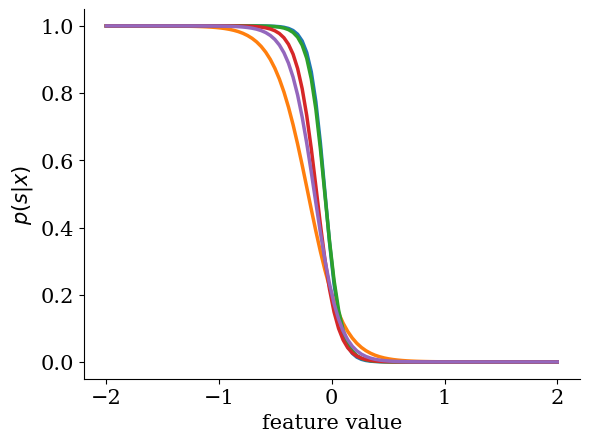

In [ ]:
_W, _b = sess.run([W, b])
x = np.linspace(-2, 2, 100)

def sigmoid(logits):
    return 1 / (1 + np.exp(-logits))


plt.figure()

for d in range(D // 2):
    logits = _W[0][0][d] * (x - _b[0][0][d])
    psx = sigmoid(logits)
    plt.plot(x, psx)

plt.xlabel('feature value')
plt.ylabel('$p(s|x)$')
plt.show()
plt.close()

In [ ]:
_W, _b

(array([[[-15.064675 ,  -6.5605564, -13.927918 , -11.371145 ,
           -9.007028 ,   4.712978 ,  -2.2390034,  -1.4327152,
           -5.2509413,   4.3905253,   4.8927236]]], dtype=float32),
 array([[[-0.05938366, -0.2097743 , -0.06150096, -0.13324064,
          -0.15291208, -5.173197  ,  6.1473246 ,  6.939733  ,
           6.0418167 , -5.5806217 , -5.021612  ]]], dtype=float32))

This should illustrate that the probability of the feature value being observed when it is below the feature mean should be close to 1, while the probability of being observed above the feature mean should be close to 0.

### Close the session

In [ ]:
# sess.close()